In [1]:
# Carregant les llibreries necessàries
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import collections as col
import scipy.stats as stats
import statsmodels.api as sm
import scipy.stats
import random as rand
import matplotlib.gridspec as gridspec
from sklearn.preprocessing import LabelEncoder, StandardScaler, scale
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, HuberRegressor, RANSACRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error , r2_score
import warnings
import time
warnings.filterwarnings("ignore")
import pandas as pd
from shapely.geometry import  Point #conda install -c conda-forge shapely
import geopandas as gpd #pip install geopandas
import matplotlib.pyplot as plt
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import seaborn as sns
import contextily as ctx #pip3 install contextily

In [21]:
# Carregant les llibreries necessàries
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
colors = sns.set_palette('Set2',8)
import warnings
warnings.filterwarnings("ignore")

lon_lat = (-122.5247, -122.3366, 37.699, 37.8299)
mapdata = np.loadtxt("sf_map_copyright_openstreetmap_contributors.txt")

In [3]:
# Obrint el dataset
dataset = pd.read_csv('./train.csv')
print(f'Mida de les dades: {dataset.shape}')
dataset.head()

Mida de les dades: (878049, 9)


,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


In [4]:
ds_copy = dataset.copy()

## EDA

#### NETEJA DEL CONJUNT DE DADES

In [5]:
# Mirem si hi ha NaNs
print(pd.isnull(ds_copy).values.sum())

0


In [6]:
# Eliminar dades duplicades
ds_copy.drop_duplicates(subset=None,keep="first",inplace=True)
print('Mida original: ',dataset.shape,
     '\nNº de dades repetides: ', dataset.duplicated().sum(),
     '\nMida un cop fet el drop: ',ds_copy.shape)

Mida original:  (878049, 9) 
Nº de dades repetides:  2323 
Mida un cop fet el drop:  (875726, 9)


In [7]:
# Eliminar dades incoherents
ds_copy.describe()

,X,Y
count,875726.000000,875726.000000
mean,-122.422623,37.771032
std,0.030363,0.457497
min,-122.513642,37.707879
25%,-122.432952,37.752427
50%,-122.416446,37.775421
75%,-122.406959,37.784380
max,-120.500000,90.000000


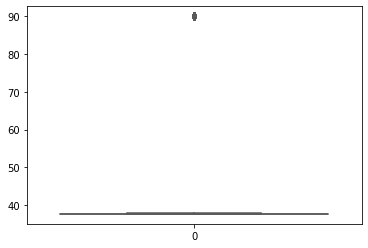

In [8]:
# Eliminar datdes fora de San Francisco
sns.boxplot(ds_copy['Y'])
ds_copy = ds_copy[ds_copy['Y'] <= 40]

In [9]:
ds_copy.describe()

,X,Y
count,875659.000000,875659.000000
mean,-122.422770,37.767036
std,0.025281,0.024166
min,-122.513642,37.707879
25%,-122.432952,37.752427
50%,-122.416446,37.775421
75%,-122.406959,37.784380
max,-122.364937,37.819975


#### ANÀLISI VARIABLES EXPLICATIVES

In [10]:
# Dates
ds_copy['Dates'] = pd.to_datetime(ds_copy['Dates'], format='%Y-%m-%d %H:%M:%S')
ds_copy['Year'] = ds_copy['Dates'].dt.year
DateAnalisi = ds_copy.copy()
DateAnalisi['Day'] = ds_copy['Dates'].dt.day
DateAnalisi['Hour'] = ds_copy['Dates'].dt.hour
DateAnalisi['Minute'] = ds_copy['Dates'].dt.minute
DateAnalisi['Month'] = ds_copy['Dates'].dt.month
DateAnalisi[['Year','Month','Day','Hour','Minute']].describe()

,Year,Month,Day,Hour,Minute
count,875659.000000,875659.000000,875659.000000,875659.000000,875659.000000
mean,2008.712484,6.436043,15.573172,13.413670,20.170046
std,3.631338,3.429085,8.782849,6.549138,18.595969
min,2003.000000,1.000000,1.000000,0.000000,0.000000
25%,2006.000000,3.000000,8.000000,9.000000,0.000000
50%,2009.000000,6.000000,16.000000,14.000000,19.000000
75%,2012.000000,9.000000,23.000000,19.000000,33.000000
max,2015.000000,12.000000,31.000000,23.000000,59.000000


In [11]:
# Descript
print("Valors únics:", ds_copy['Descript'].nunique())
ct_Desc = pd.crosstab(ds_copy['Descript'], ds_copy['Category']); ct_Desc
stack_Desc = ct_Desc.stack().reset_index().rename(columns = {0:'count'}); stack_Desc
sum_Desc = ct_Desc.sum().reset_index().rename(columns = {0:'total'}); sum_Desc
DescrMerge = stack_Desc.merge(sum_Desc); DescrMerge
DescrData = DescrMerge[DescrMerge['count'] != 0].sort_values(by=['count','Category'], ascending=False).reset_index(drop = True)
DescrData['%'] = DescrData['count']/DescrData['total']*100
DescrData = DescrData.drop(columns = ['count','total'])
temp = pd.DataFrame()
for c in (DescrData['Category'].unique()):
    aux = DescrData[DescrData['Category'] == c]
    temp = pd.concat([temp, aux[0:1]])
temp.reset_index(drop=True)

Valors únics: 879


,Descript,Category,%
0,GRAND THEFT FROM LOCKED AUTO,LARCENY/THEFT,34.282436
1,LOST PROPERTY,NON-CRIMINAL,34.270109
2,BATTERY,ASSAULT,35.691503
3,STOLEN AUTOMOBILE,VEHICLE THEFT,50.025141
4,"DRIVERS LICENSE, SUSPENDED OR REVOKED",OTHER OFFENSES,21.292966
5,WARRANT ARREST,WARRANTS,56.242732
6,SUSPICIOUS OCCURRENCE,SUSPICIOUS OCC,69.686544
7,"MALICIOUS MISCHIEF, VANDALISM OF VEHICLES",VANDALISM,39.739794
8,POSSESSION OF NARCOTICS PARAPHERNALIA,DRUG/NARCOTIC,18.620523
9,FOUND PERSON,MISSING PERSON,35.899334


Friday       133360
Wednesday    128818
Saturday     126463
Thursday     124746
Tuesday      124592
Monday       121292
Sunday       116388
Name: DayOfWeek, dtype: int64


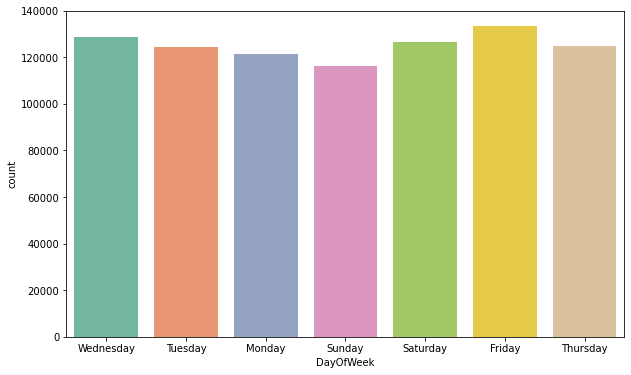

In [12]:
# Day Of Week
print(ds_copy['DayOfWeek'].value_counts())
fig = plt.figure(figsize=(10,6))
sns.countplot(x=ds_copy['DayOfWeek'])

SOUTHERN      156520
MISSION       119722
NORTHERN      105093
BAYVIEW        89089
CENTRAL        85262
TENDERLOIN     81627
INGLESIDE      78718
TARAVAL        65396
PARK           49159
RICHMOND       45073
Name: PdDistrict, dtype: int64


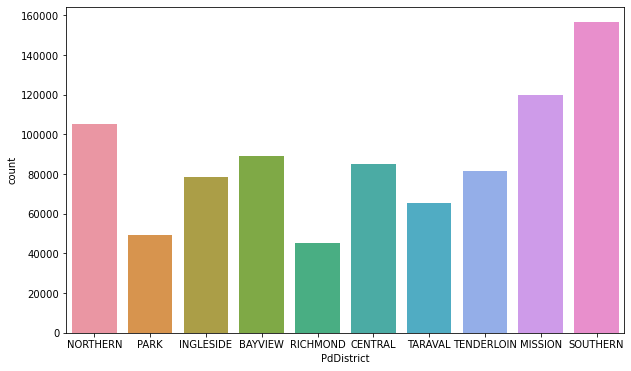

In [13]:
# PdDistrict
print(ds_copy['PdDistrict'].value_counts())
fig = plt.figure(figsize=(10,6))
sns.countplot(x=ds_copy['PdDistrict'])

NONE                                      525089
ARREST, BOOKED                            206154
ARREST, CITED                              76822
LOCATED                                    16889
PSYCHOPATHIC CASE                          14528
UNFOUNDED                                   9576
JUVENILE BOOKED                             5563
COMPLAINANT REFUSES TO PROSECUTE            3967
DISTRICT ATTORNEY REFUSES TO PROSECUTE      3934
NOT PROSECUTED                              3710
JUVENILE CITED                              3322
PROSECUTED BY OUTSIDE AGENCY                2503
EXCEPTIONAL CLEARANCE                       1528
JUVENILE ADMONISHED                         1451
JUVENILE DIVERTED                            355
CLEARED-CONTACT JUVENILE FOR MORE INFO       217
PROSECUTED FOR LESSER OFFENSE                 51
Name: Resolution, dtype: int64


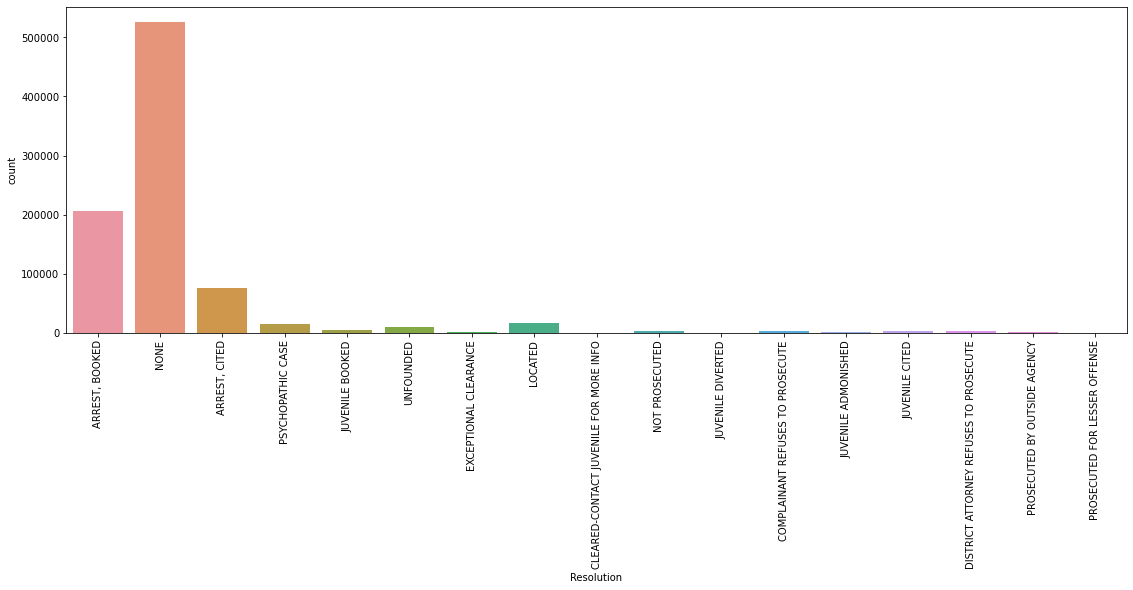

In [17]:
# Resolution
print(ds_copy['Resolution'].value_counts())
fig, ax = plt.subplots(1, 1, figsize=(19, 6))
sns.countplot(x=ds_copy['Resolution'])
ax.tick_params(axis='x', rotation=90)

In [114]:
Add = pd.DataFrame()
Add = ds_copy[['Address','X','Y']]
Add_unique = Add.round(7).drop_duplicates().sort_values(by=['Address'], ascending=False).reset_index(drop = True); Add_unique

,Address,X,Y
0,ZOE ST / WELSH ST,-122.396309,37.780097
1,ZOE ST / FREELON ST,-122.395839,37.779720
2,ZOE ST / BRYANT ST,-122.396849,37.780528
3,ZOE ST / BRANNAN ST,-122.395309,37.779297
4,ZENO PL / FOLSOM ST,-122.393308,37.788226
...,...,...,...
36340,0 Block of 10TH ST,-122.417160,37.776347
36341,0 Block of 10TH ST,-122.417258,37.776269
36342,0 Block of 10TH AV,-122.469055,37.786629
36343,0 Block of 10TH AV,-122.468917,37.786638


In [118]:
Add_unique.groupby(by=['Address']).size()

Address
0 Block of  HARRISON ST    1
0 Block of 10TH AV         2
0 Block of 10TH ST         5
0 Block of 11TH ST         2
0 Block of 12TH AV         2
                          ..
ZENO PL / FOLSOM ST        1
ZOE ST / BRANNAN ST        1
ZOE ST / BRYANT ST         1
ZOE ST / FREELON ST        1
ZOE ST / WELSH ST          1
Length: 23191, dtype: int64

In [9]:
# Crims simultanis
ds_MultCrims = ds_copy.groupby(['Dates', 'X', 'Y']).size()
ds_MultCrims = pd.DataFrame(ds_MultCrims)
ds_MultCrims = ds_MultCrims.reset_index(drop=True)
ds_copy = ds_copy.merge(ds_MultCrims, how='right')
ds_copy.rename(columns={0:'NumMultCrims'}, inplace=True)

In [11]:
ds_copy['NumMultCrims'].value_counts()/sorted(ds_copy['NumMultCrims'].unique())

1     551788.0
2      96925.0
3      33855.0
4       4195.0
5       1355.0
6        434.0
7        159.0
8         69.0
9         38.0
10        13.0
11         9.0
12         4.0
13         1.0
Name: NumMultCrims, dtype: float64

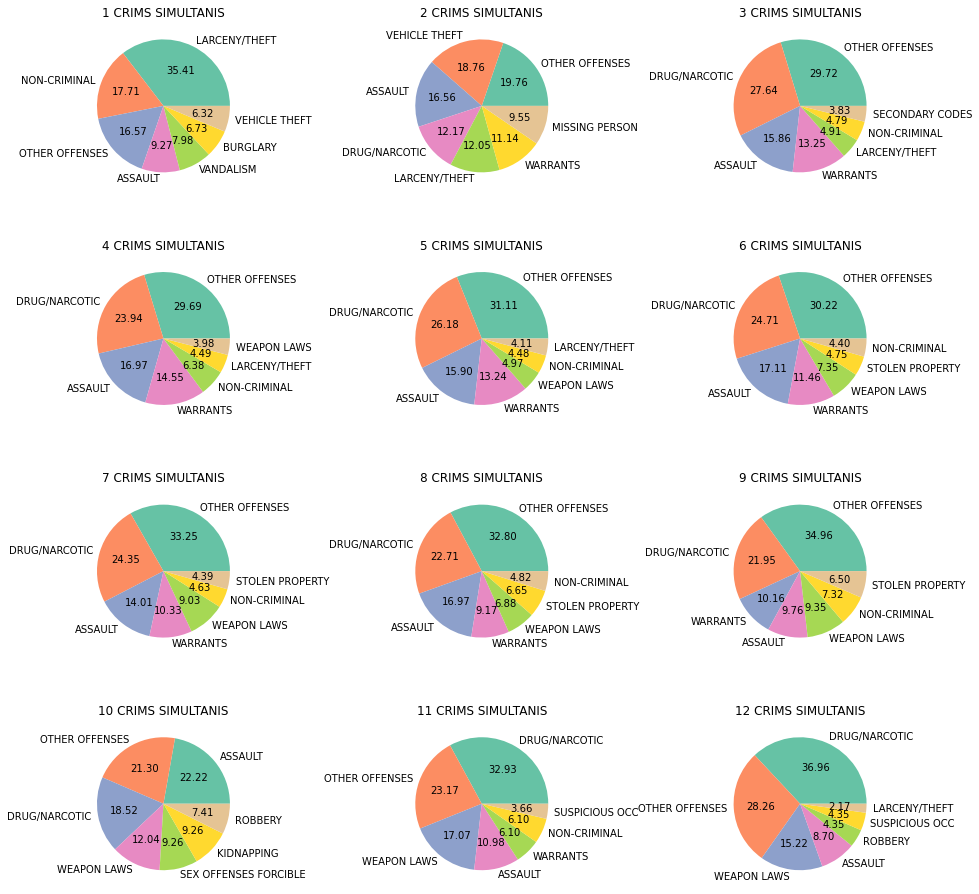

In [43]:
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(15,15))
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
i=0
for r in range(4):
    for c in range(3):
        if (i < ds_copy['NumMultCrims'].nunique()):
            aux = ds_copy[ds_copy['NumMultCrims'] == i+1]
            im = ax[r, c].pie(aux['Category'].value_counts()[0:7], labels= aux['Category'].value_counts().keys()[0:7],
               colors = colors, autopct = '%.2f')
            ax[r, c].set_title("{} CRIMS SIMULTANIS".format(i+1))
            i=i+1
plt.show()

Ens donem compta que la categoria "Other offenses" el 83.43% de les vegades dins del conjut de dades es dona juntament amb altres cris simultanis. Una altra categoria candidata a ser classificada juntament amb una altra categoria és "Drug/Narcotic"

In [106]:
# Crims sense resolució
NoneData = ds_copy[ds_copy['Resolution'] == 'NONE']
print("El {:.2f}% de les dades del dataset original són crims no resolts".format(NoneData.size/ds_copy.size*100))

El 59.97% de les dades del dataset original són crims no resolts


SOUTHERN      93415
NORTHERN      70098
MISSION       62930
CENTRAL       60221
BAYVIEW       51551
INGLESIDE     50954
TARAVAL       44908
RICHMOND      32623
PARK          30795
TENDERLOIN    27594
Name: PdDistrict, dtype: int64


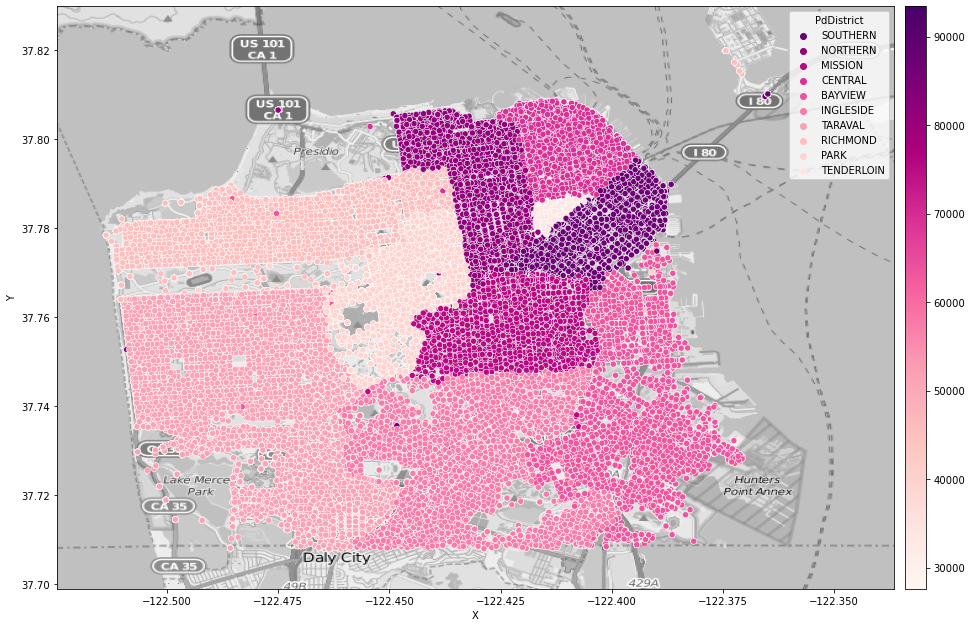

In [108]:
fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(1,1,1)
ax1.imshow(mapdata,extent=lon_lat, cmap=plt.get_cmap('gray'))
print(NoneData['PdDistrict'].value_counts())

hue_order = list(NoneData['PdDistrict'].value_counts().keys())
sc = sns.scatterplot(x = NoneData['X'], y = NoneData['Y'], hue = NoneData['PdDistrict'], hue_order = hue_order, palette='RdPu_r')
norm = plt.Normalize(NoneData['PdDistrict'].value_counts().max(), NoneData['PdDistrict'].value_counts().min())
sm = plt.cm.ScalarMappable(cmap='RdPu', norm=norm)
cax = fig.add_axes([ax1.get_position().x1+0.01,ax1.get_position().y0,0.02,ax1.get_position().height])
ax1.figure.colorbar(sm, cax = cax)
plt.show()

Friday       82347
Saturday     77982
Wednesday    74322
Thursday     73839
Tuesday      72711
Monday       72559
Sunday       71329
Name: DayOfWeek, dtype: int64


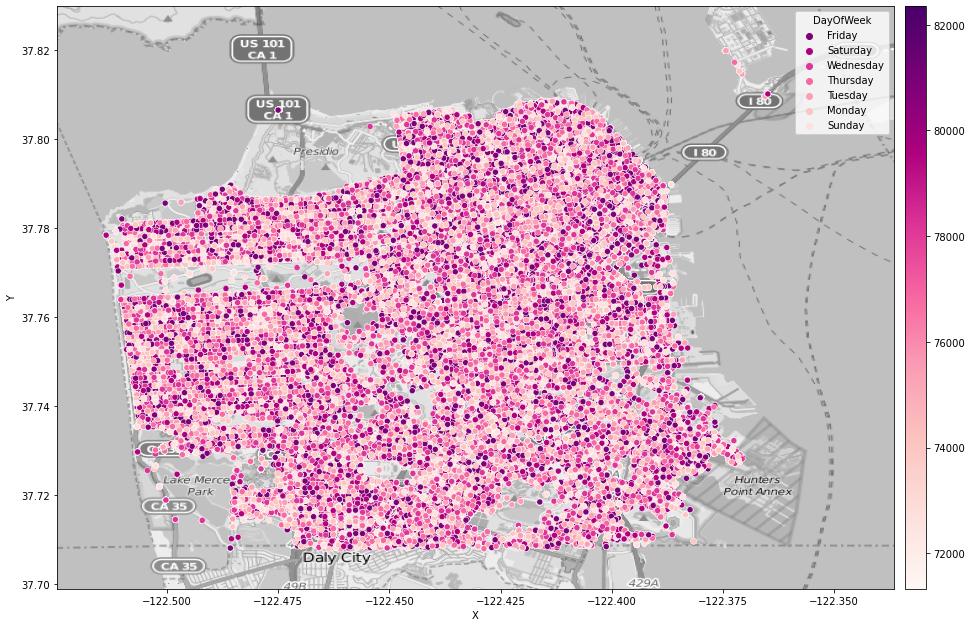

In [97]:
fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(1,1,1)
ax1.imshow(mapdata,extent=lon_lat, cmap=plt.get_cmap('gray'))
print(NoneData['DayOfWeek'].value_counts())

hue_order = list(NoneData['DayOfWeek'].value_counts().keys())
sc = sns.scatterplot(x = NoneData['X'], y = NoneData['Y'], hue = NoneData['DayOfWeek'], hue_order = hue_order, palette='RdPu_r')
norm = plt.Normalize(NoneData['DayOfWeek'].value_counts().max(), NoneData['DayOfWeek'].value_counts().min())
sm = plt.cm.ScalarMappable(cmap='RdPu', norm=norm)
cax = fig.add_axes([ax1.get_position().x1+0.01,ax1.get_position().y0,0.02,ax1.get_position().height])
ax1.figure.colorbar(sm, cax = cax)
plt.show()

D'aquestes dues gràfiques podem veure que tot i ser dades bastant equivalents, el districte amb més casos sense resoldre és el 'SOUTHERN' i el dia de la setmana amb més casos sense resoldre és 'Friday'

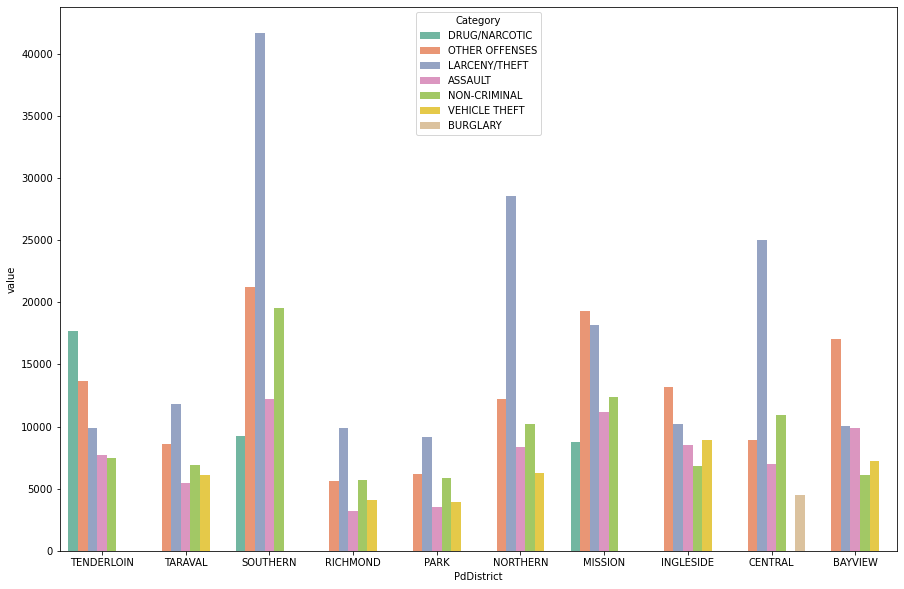

In [109]:
# Classificació majoritària per districte
ctDist_Cat = pd.crosstab(ds_copy['PdDistrict'], ds_copy['Category'])
Dist_Cat= ctDist_Cat.stack().reset_index().rename(columns= {0:'value'})
Dist_Cat2 = Dist_Cat.sort_values(by=['PdDistrict','value'], ascending=False).reset_index()
temp = pd.DataFrame()
for d in (Dist_Cat2['PdDistrict'].unique()):
    aux = Dist_Cat2[Dist_Cat2['PdDistrict'] == d]
    temp = pd.concat([temp, aux[0:5]])
fig, bar= plt.subplots(figsize= (15,10))
bar= sns.barplot(x= temp['PdDistrict'], y= temp['value'], hue= temp['Category'], palette='Set2')

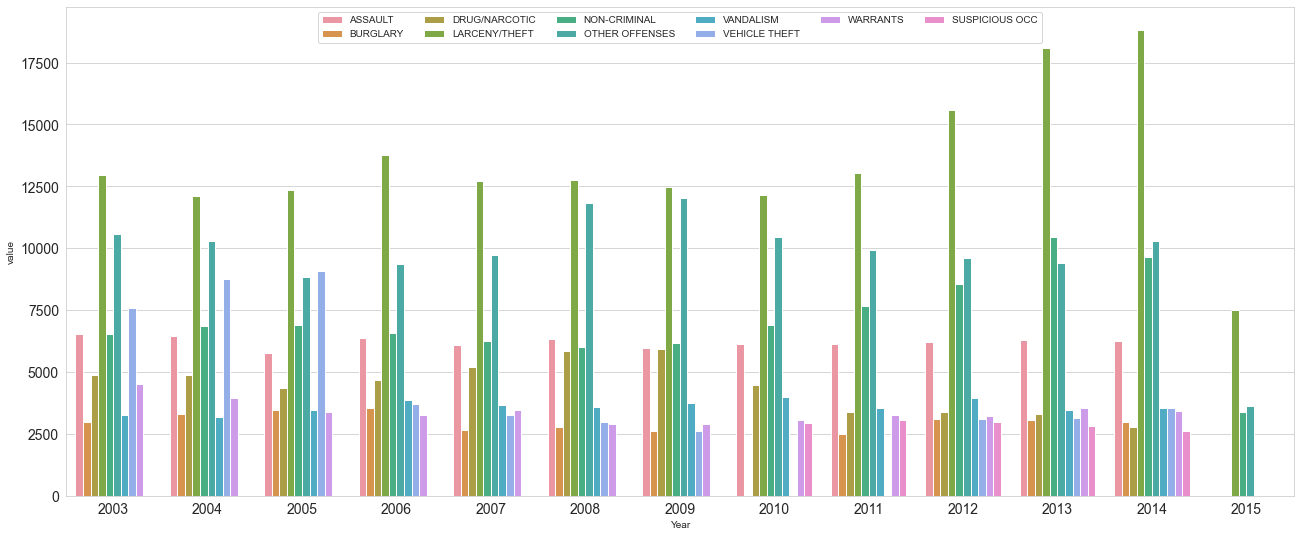

In [112]:
# Classificació majoritària per any
ct_year = pd.crosstab(ds_copy['Year'], ds_copy['Category'])
StackYear= ct_year.stack().reset_index().rename(columns= {0:'value'})
StackYear = StackYear[StackYear['value'] > 2500]
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(22, 9))
ax = sns.barplot(x=StackYear['Year'], y=StackYear['value'],  hue=StackYear['Category'])
ax.legend(loc='best',ncol=6)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

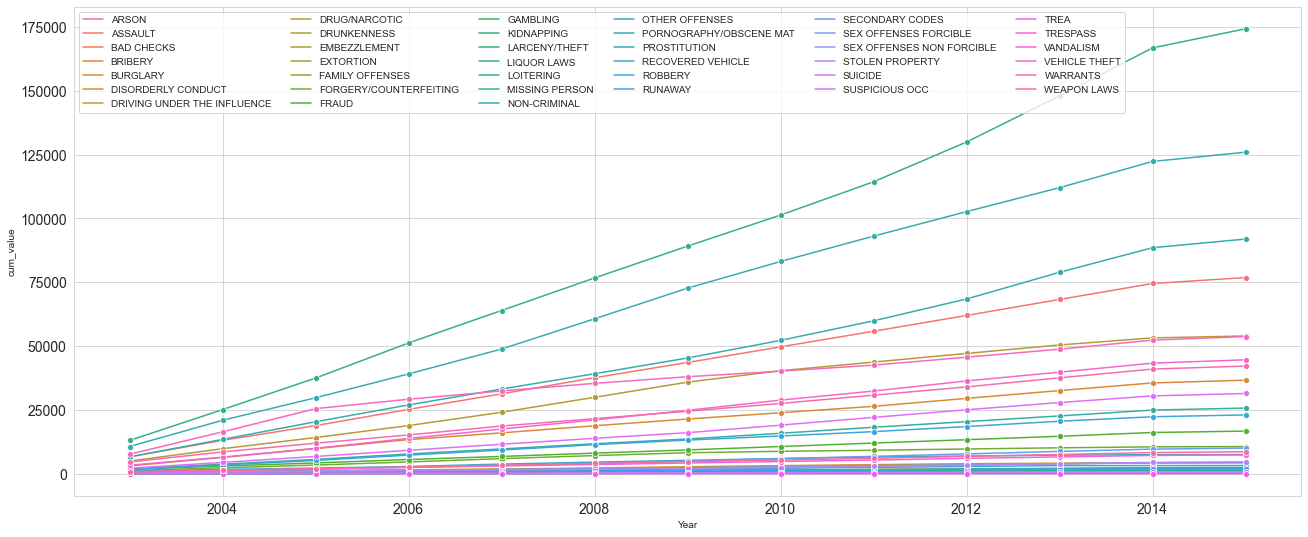

In [113]:
# Creixement anual per classificació
ct_year = pd.crosstab(ds_copy['Year'], ds_copy['Category'])
cm_year = ct_year.cumsum()
StackYear= cm_year.stack().reset_index().rename(columns = {0:'cum_value'})

sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(22, 9))
ax = sns.lineplot(x=StackYear['Year'], y=StackYear['cum_value'],  hue=StackYear['Category'], marker="o")
ax.legend(loc='best',ncol=6)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

##### ANÁLISIS VARIABLE RESPOSTA

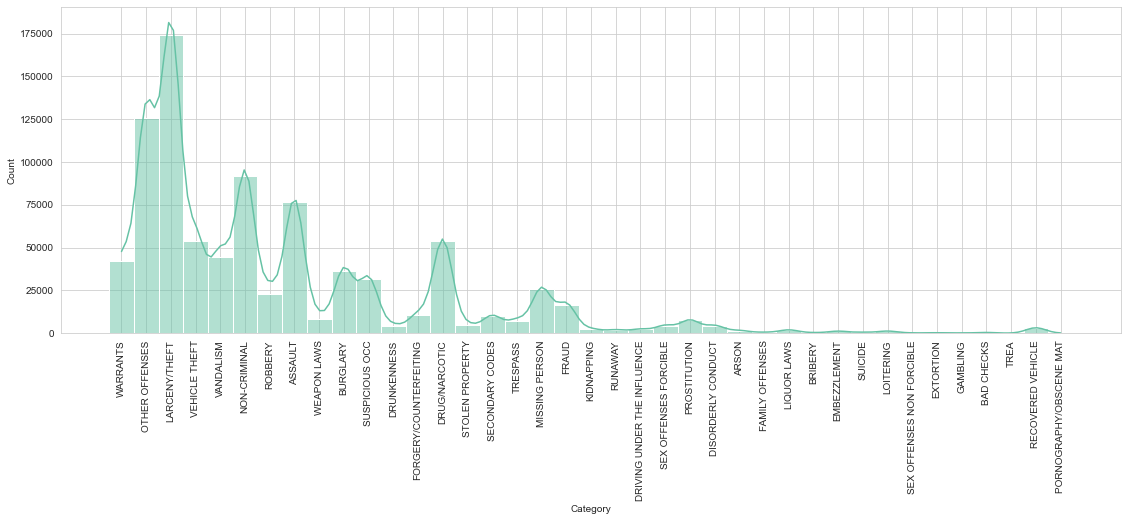

In [114]:
fig, ax = plt.subplots(1, 1, figsize=(19, 6))
sns.histplot(x='Category', data=ds_copy, kde=True, palette='rocket', ax=ax)
ax.tick_params(axis='x', rotation=90)